# Assignment

In [1]:
# Import 
import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 3 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 2 0 0]]
check?  0
dofk2  1

[[0 3 0 0]
 [0 0 0 2]
 [0 0 0 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[3 0 0 0]
 [0 0 0 2]
 [0 0 1 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [3 0 0 0]
 [0 0 1 2]
 [0 0 0 0]]
0  0
check?  0
dofk2  2

[[0 3 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 2]]
0  0
check?  0
dofk2  3

[[0 0 3 0]
 [0 0 0 0]
 [0 0 1 0]
 [2 0 0 0]]
0  0
check?  0
dofk2  1


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.198 Number of steps:  6.981


In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

################## INITALISE YOUR NEURAL NETWORK.########################################
#Epsilon_Greedy Policy. Filter for the valid ones.
#https://keras.io/examples/rl/deep_q_network_breakout/

def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a):
    rand_value=np.random.uniform(0,1)
    rand_a=rand_value<epsilon
    if rand_a==True:
        a,_=np.where(allowed_a==1)
        return np.random.permutation(a)[0]
    else:#
        Qvalues = Qvalues.numpy()
        #set the qvalues for not allowed actions to negative infinity, so that they won't be picked.
        Qvalues[np.transpose(allowed_a)==0] = np.NINF
        result = np.argmax(Qvalues)
        return result

    
#Network    
def define_q_model(N_in, N_h, N_a):
    #input layer
    inputs =layers.Input(shape=(N_in,))
    #hidden layer 1
    # Initializing weights at 0s made it start from a much better state (compared to random one).
    layer1 = layers.Dense(N_h, activation="relu", bias_initializer='zeros', kernel_initializer='zeros')(inputs)
    #output layer
    action = layers.Dense(N_a, activation="linear", bias_initializer='zeros', kernel_initializer='zeros')(layer1)
    return keras.Model(inputs=inputs, outputs=action)

#update our model
def update_q_model(model, frozen_model, optimizer, gamma, state_history, state_next_history, action_history, rewards_history, done_history):
    # Pick batch_size random states from history to build a training batch.
    # 
    indices = np.random.choice(range(len(state_history)), size = batch_size)
    sample_state_history = [state_history[i] for i in indices]
    sample_action_history = [action_history[i] for i in indices]
    sample_state_next_history = [state_next_history[i] for i in indices]
    sample_rewards_history = [rewards_history[i] for i in indices]
    # done= 0 or 1 depending on the game's state(finished or not)
    sample_done_history = [done_history[i] for i in indices]
    
    #masks for actions taken
    masks = tf.one_hot(np.array(sample_action_history), N_a)
    #q values for every action taken in S' from the frozen (target) network!!! *not* model.
    future_q_values = frozen_model(np.array(sample_state_next_history))
    # Q-learning, pick the max q value
    max_future_q_values = tf.reduce_max(future_q_values, axis=1)
    
    
    # Only consider stuff inside tape when computing gradients for the model!
    with tf.GradientTape() as tape:
        #q values for every action taken
        q_values = model(np.array(sample_state_history))
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        updated_q_values = np.array(sample_rewards_history) + gamma * max_future_q_values * (1 - np.array(sample_done_history))
        loss = loss_function(updated_q_values, q_values_masked)
    gradients = tape.gradient(loss, model.trainable_variables)
    #Pass the gradients and variables to optimizer so it can do it's thing.
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    
    
    
    

####################################################################################


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.0001      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])

# History buffer(how far I should know betwen past and present) size.
H_size = 100000
batch_size = 64
# How many batches to train when updating model.
batches_per_training = 2
update_after_actions = 2
update_frozen_model_actions = 5000

In [6]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

# Create a q model
q_model = define_q_model(N_in, N_h, N_a)
# And a frozen copy
frozen_model = define_q_model(N_in, N_h, N_a)
frozen_model.set_weights(q_model.get_weights())

# Create an Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=eta, clipnorm=1.0)
loss_function = keras.losses.Huber()

#accumulate history for batch 
state_history      = []
state_next_history = []
action_history     = []
rewards_history    = []
done_history       = []

R_save_q = []
N_moves_save_q = []
N_actions = 0

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        #a,_=np.where(allowed_a==1)
        #a_agent=np.random.permutation(a)[0]
        
        #applying my model to the state
        Qvalues = q_model(tf.expand_dims(X, 0), training=False)
        
        a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, allowed_a)
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        
        # Add new values to history
        if (len(state_history) < H_size):
            state_history.append(np.copy(X))
            state_next_history.append(np.copy(X_next))
            action_history.append(a_agent)
            rewards_history.append(R)
            done_history.append(Done)
        # Reuse old history once buffers are full.
        else:
            state_history[N_actions % H_size]      = np.copy(X)
            state_next_history[N_actions % H_size] = np.copy(X_next)
            action_history[N_actions % H_size]     = a_agent
            rewards_history[N_actions % H_size]    = R
            done_history[N_actions % H_size]       = Done
        N_actions += 1
        # Update model's variables.
        if N_actions % update_after_actions == 0 and len(state_history) > batch_size:
            for i in range(batches_per_training):
                update_q_model(
                    q_model,
                    frozen_model,
                    optimizer, 
                    gamma, 
                    state_history, 
                    state_next_history, 
                    action_history, 
                    rewards_history, 
                    done_history)

        # Update frozen model with current model
        if N_actions % update_frozen_model_actions == 0:
            frozen_model.set_weights(q_model.get_weights())
            print('Q_Agent, Average reward:',np.mean(R_save_q),'Number of steps: ',np.mean(N_moves_save_q), 'Episodes: ', n)
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Keep a reward and moves history to make pretty graphs.
            R_save_q.append(R)
            N_moves_save_q.append(i)
            break
        # IF THE EPISODE IS NOT OVER...
        else:
            ## ONLY TO PUT SUMETHING
            PIPPO=1            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
print('Q_Agent, Average reward:',np.mean(R_save_q),'Number of steps: ',np.mean(N_moves_save_q))

Q_Agent, Average reward: 0.32085561497326204 Number of steps:  1.427807486631016 Episodes:  374
Q_Agent, Average reward: 0.4169014084507042 Number of steps:  1.3957746478873239 Episodes:  710
Q_Agent, Average reward: 0.46314831665150136 Number of steps:  1.3939945404913558 Episodes:  1099
Q_Agent, Average reward: 0.46615491974877876 Number of steps:  1.4068387997208653 Episodes:  1433
Q_Agent, Average reward: 0.4733595064498037 Number of steps:  1.4054963544587773 Episodes:  1783
Q_Agent, Average reward: 0.4835216572504708 Number of steps:  1.4067796610169492 Episodes:  2124
Q_Agent, Average reward: 0.49299719887955185 Number of steps:  1.4061624649859943 Episodes:  2499
Q_Agent, Average reward: 0.4946808510638298 Number of steps:  1.4113475177304964 Episodes:  2820
Q_Agent, Average reward: 0.4996839443742099 Number of steps:  1.4102402022756004 Episodes:  3164
Q_Agent, Average reward: 0.5073654390934844 Number of steps:  1.406515580736544 Episodes:  3530
Q_Agent, Average reward: 0.516

Q_Agent, Average reward: 0.5798940161683364 Number of steps:  1.4033187637798321 Episodes:  25853
Q_Agent, Average reward: 0.5795441486305305 Number of steps:  1.4032560812104962 Episodes:  26105
Q_Agent, Average reward: 0.5796881520543268 Number of steps:  1.4037330702985698 Episodes:  26359
Q_Agent, Average reward: 0.5804662319166479 Number of steps:  1.4030057716812832 Episodes:  26682
Q_Agent, Average reward: 0.5803995840760546 Number of steps:  1.4034833630421866 Episodes:  26928
Q_Agent, Average reward: 0.5801566003749586 Number of steps:  1.4031540638900122 Episodes:  27203
Q_Agent, Average reward: 0.5809763022824069 Number of steps:  1.403552837537767 Episodes:  27471
Q_Agent, Average reward: 0.5813332370881005 Number of steps:  1.4032915869635831 Episodes:  27707
Q_Agent, Average reward: 0.5819467257016354 Number of steps:  1.4032350210669142 Episodes:  28006
Q_Agent, Average reward: 0.5819280941775374 Number of steps:  1.4033301516597732 Episodes:  28287
Q_Agent, Average rewa

Q_Agent, Average reward: 0.5934244088020405 Number of steps:  1.4016687562146037 Episodes:  46262
Q_Agent, Average reward: 0.5936848888411557 Number of steps:  1.4017828375040275 Episodes:  46555
Q_Agent, Average reward: 0.5938435228730227 Number of steps:  1.4015604959384351 Episodes:  46780
Q_Agent, Average reward: 0.5938722571865963 Number of steps:  1.4015563871406702 Episodes:  47032
Q_Agent, Average reward: 0.5939655537218061 Number of steps:  1.4015911302949515 Episodes:  47262
Q_Agent, Average reward: 0.5941217340042529 Number of steps:  1.4014990420447606 Episodes:  47497
Q_Agent, Average reward: 0.5937074509311046 Number of steps:  1.4013699490982217 Episodes:  47739
Q_Agent, Average reward: 0.5934221482098252 Number of steps:  1.401353039134055 Episodes:  48040
Q_Agent, Average reward: 0.5935720350390358 Number of steps:  1.4014785976102218 Episodes:  48289
Q_Agent, Average reward: 0.5935503812075005 Number of steps:  1.4015660416237379 Episodes:  48530
Q_Agent, Average rewa

Q_Agent, Average reward: 0.5971070277535933 Number of steps:  1.4011364157081978 Episodes:  65469
Q_Agent, Average reward: 0.5969013484308892 Number of steps:  1.4011657991659818 Episodes:  65706
Q_Agent, Average reward: 0.5969441118067029 Number of steps:  1.4010246926679906 Episodes:  65971
Q_Agent, Average reward: 0.5970838616192718 Number of steps:  1.401135060073658 Episodes:  66252
Q_Agent, Average reward: 0.5971549727827734 Number of steps:  1.401221015909296 Episodes:  66502
Q_Agent, Average reward: 0.5972141004303301 Number of steps:  1.4013014859130644 Episodes:  66693
Q_Agent, Average reward: 0.597057505601195 Number of steps:  1.4011799850634803 Episodes:  66950
Q_Agent, Average reward: 0.5971426445420046 Number of steps:  1.4011905647741647 Episodes:  67195
Q_Agent, Average reward: 0.5972584856396866 Number of steps:  1.4013321860906718 Episodes:  67408
Q_Agent, Average reward: 0.5970804213885729 Number of steps:  1.401220431140202 Episodes:  67681
Q_Agent, Average reward:

Q_Agent, Average reward: 0.6003112436778628 Number of steps:  1.402270664104408 Episodes:  84821
Q_Agent, Average reward: 0.6004115226337449 Number of steps:  1.4024573780129335 Episodes:  85050
Q_Agent, Average reward: 0.6005533541231917 Number of steps:  1.402424441370255 Episodes:  85298
Q_Agent, Average reward: 0.600549418434742 Number of steps:  1.4023613302939972 Episodes:  85545
Q_Agent, Average reward: 0.6007506614912986 Number of steps:  1.4022333344989568 Episodes:  85791
Q_Agent, Average reward: 0.6007878041412005 Number of steps:  1.4020706002649252 Episodes:  86062
Q_Agent, Average reward: 0.6008555331432148 Number of steps:  1.4021237624910157 Episodes:  86262
Q_Agent, Average reward: 0.6008928674693221 Number of steps:  1.4021026334964088 Episodes:  86463
Q_Agent, Average reward: 0.6009644781319582 Number of steps:  1.4021043159242723 Episodes:  86679
Q_Agent, Average reward: 0.600925243969803 Number of steps:  1.4021473945866323 Episodes:  86896
Q_Agent, Average reward:

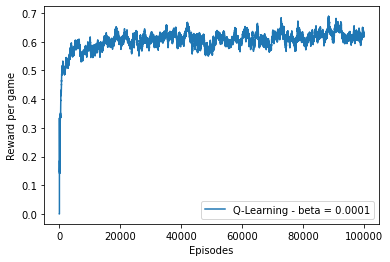

In [7]:
# Reward per game using an exponential average with 500 decay.
R_ma_q = pd.DataFrame({'R': R_save_q}).ewm(com=400).mean()

plt.plot(R_ma_q, label="Q-Learning - beta = 0.0001")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Reward per game")
plt.savefig(f"q_rewards_{N_episodes}_beta_0.0001.pdf")

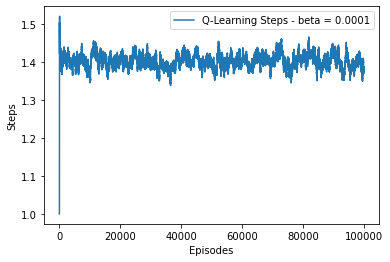

In [8]:
# Reward per game using an exponential average with 500 decay.
N_ma_q = pd.DataFrame({'N': N_moves_save_q}).ewm(com=400).mean()
plt.plot(N_ma_q, label="Q-Learning Steps - beta = 0.0001")
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.legend()
plt.savefig(f"q_steps_{N_episodes}_beta_0.0001.pdf")